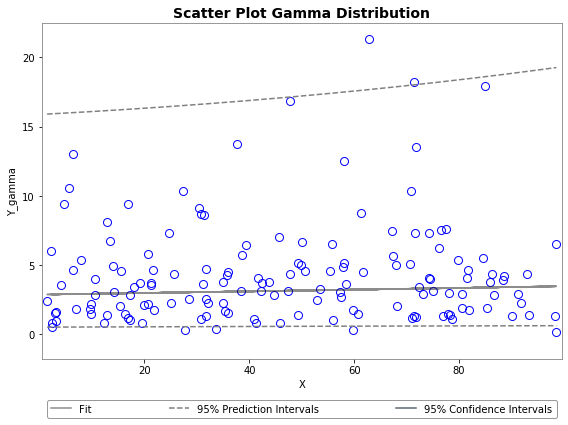

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy as sp 
import scipy.stats as stats

# genereaza y
y_gamma = np.random.gamma(shape = 2.0, scale = 2.0 , size = 150)
y_gamma_log=[math.log(i) for i in y_gamma]
# genereaza x
sp.random.seed(123345) 
x=sp.random.uniform(low=1,high=100,size=150) 

def plot_ci_manual(t, s_err, n, x, x2, y2, ax=None):
    """Return an axes of confidence bands using a simple approach.

    Notes
    -----
    .. math:: \left| \: \hat{\mu}_{y|x0} - \mu_{y|x0} \: \right| \; \leq \; T_{n-2}^{.975} \; \hat{\sigma} \; \sqrt{\frac{1}{n}+\frac{(x_0-\bar{x})^2}{\sum_{i=1}^n{(x_i-\bar{x})^2}}}
    .. math:: \hat{\sigma} = \sqrt{\sum_{i=1}^n{\frac{(y_i-\hat{y})^2}{n-2}}}

    References
    ----------
    .. [1] M. Duarte.  "Curve fitting," Jupyter Notebook.
       http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/CurveFitting.ipynb

    """
    if ax is None:
        ax = plt.gca()

    ci = t * s_err * np.sqrt(1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    ax.fill_between(x2, y2 + ci, y2 - ci, color="#b9cfe7", edgecolor="")

    return ax


def plot_ci_bootstrap(xs, ys, resid, nboot=500, ax=None):
    """Return an axes of confidence bands using a bootstrap approach.

    Notes
    -----
    The bootstrap approach iteratively resampling residuals.
    It plots `nboot` number of straight lines and outlines the shape of a band.
    The density of overlapping lines indicates improved confidence.

    Returns
    -------
    ax : axes
        - Cluster of lines
        - Upper and Lower bounds (high and low) (optional)  Note: sensitive to outliers

    References
    ----------
    .. [1] J. Stults. "Visualizing Confidence Intervals", Various Consequences.
       http://www.variousconsequences.com/2010/02/visualizing-confidence-intervals.html

    """ 
    if ax is None:
        ax = plt.gca()

    bootindex = sp.random.randint

    for _ in range(nboot):
        resamp_resid = resid[bootindex(0, len(resid) - 1, len(resid))]
        # Make coeffs of for polys
        pc = sp.polyfit(xs, ys + resamp_resid, 1)                   
        # Plot bootstrap cluster
        ax.plot(xs, sp.polyval(pc, xs), "b-", linewidth=2, alpha=3.0 / float(nboot))

    return ax



# Modeling with Numpy
def equation(a, b):
    """Return a 1D polynomial."""
    return np.polyval(a, b) 

p, cov = np.polyfit(x, y_gamma_log, 1, cov=True)    # parameters and covariance from of the fit of 1-D polynom.
y_model = equation(p, x)                            # model using the fit parameters; NOTE: parameters here are coefficients

# Statistics
n = len(y_gamma_log)                                 # number of observations
m = p.size                                           # number of parameters
dof = n - m                                          # degrees of freedom
t = stats.t.ppf(0.975, n - m)                        # used for CI and PI bands

# Estimates of Error in Data/Model
resid = y_gamma_log - y_model                           
chi2 = np.sum((resid / y_model)**2)                   # chi-squared; estimates error in data
chi2_red = chi2 / dof                                 # reduced chi-squared; measures goodness of fit
s_err = np.sqrt(np.sum(resid**2) / dof)               # standard deviation of the error


# Plotting --------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 6))

# Data
ax.plot(
    x, y_gamma, "o", color="#b9cfe7", markersize=8, 
    markeredgewidth=1, markeredgecolor="b", markerfacecolor="None"
)

# Fit
y_model=[math.exp(i) for i in y_model]
ax.plot(x, y_model, "-", color="0.1", linewidth=1.5, alpha=0.5, label="Fit")  

x2 = np.linspace(np.min(x), np.max(x), 160)
y2 = equation(p, x2)

#Confidence Interval (select one)
#plot_ci_manual(t, s_err, n, x, x2, y2, ax=ax)
#plot_ci_bootstrap(x, y, resid, ax=ax)

# Prediction Interval
pi = t * s_err * np.sqrt(1 + 1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))   
ax.fill_between(x2, y2 + pi, y2 - pi, color="None", linestyle="--")
upper_line = [math.exp(i) for i in y2 - pi]
lower_line = [math.exp(i) for i in y2 + pi]
ax.plot(x2, upper_line, "--", color="0.5", label="95% Prediction Intervals")
ax.plot(x2, lower_line, "--", color="0.5")


# Figure Modifications --------------------------------------------------------
# Borders
ax.spines["top"].set_color("0.5")
ax.spines["bottom"].set_color("0.5")
ax.spines["left"].set_color("0.5")
ax.spines["right"].set_color("0.5")
ax.get_xaxis().set_tick_params(direction="out")
ax.get_yaxis().set_tick_params(direction="out")
ax.xaxis.tick_bottom()
ax.yaxis.tick_left() 

# Labels
plt.title("Scatter Plot Gamma Distribution", fontsize="14", fontweight="bold")
plt.xlabel("X")
plt.ylabel("Y_gamma")
plt.xlim(np.min(x) - 1, np.max(x) + 1)

# Custom legend
handles, labels = ax.get_legend_handles_labels()
display = (0, 1)
anyArtist = plt.Line2D((0, 1), (0, 0), color="#5c6773")    # create custom artists
legend = plt.legend(
    [handle for i, handle in enumerate(handles) if i in display] + [anyArtist],
    [label for i, label in enumerate(labels) if i in display] + ["95% Confidence Intervals"],
    loc=9, bbox_to_anchor=(0, -0.21, 1., 0.102), ncol=3, mode="expand"
)  
frame = legend.get_frame().set_edgecolor("0.5")

# Save Figure
plt.tight_layout()
#plt.savefig("ScatterPlotGammaDistribution.png", bbox_extra_artists=(legend,), bbox_inches="tight")

plt.show()

